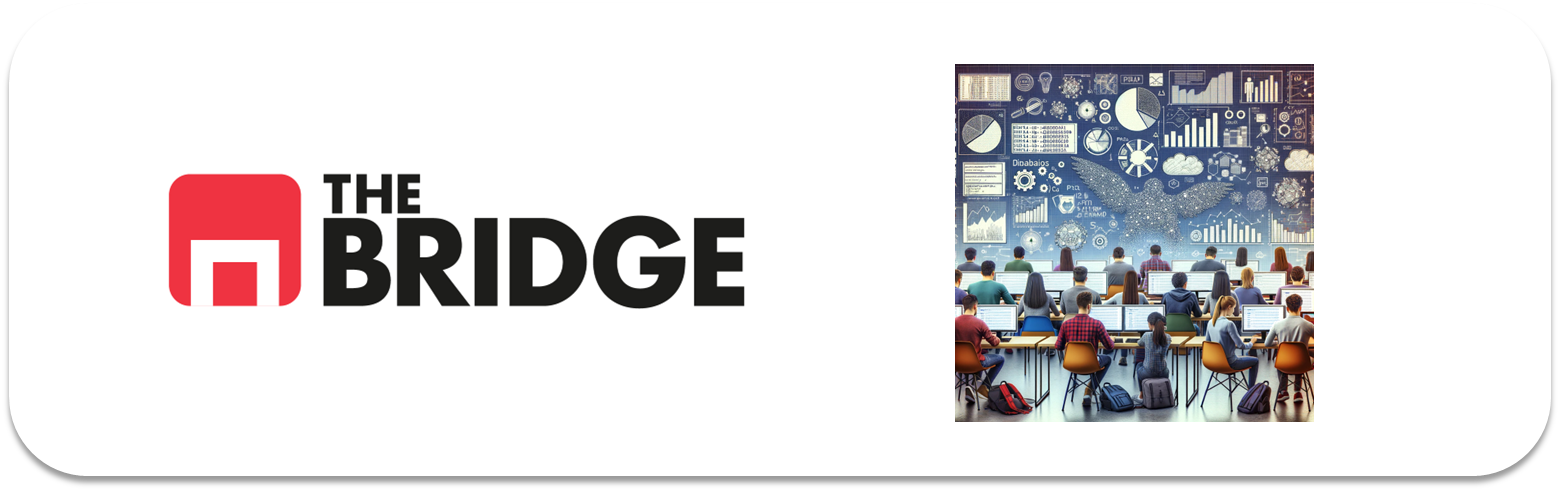

## PRACTICA OBLIGATORIA: **Clasificacion y Regresion Logistica**

* La práctica obligatoria de esta unidad consiste en modelar la supervivencia en el Titanic, por fin, además de una parte adicional multiclase. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [3]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)


### Indicaciones

A continuación tienes las indicaciones para hacer el modelado. No necesariamente tienes que seguirlos al pie de la letra, porque a partir de ahora ya las práctica obligatorias dejarán de ser mayormente guiadas por ejercicios y serán más de libre desarrollo, aunque con objetivos específicos, claros y determinados. 

En concreto se pide hacer un modelo de regresión logística, evaluarlo contra un dataset de test reservado del original mostrando las métricas propias de los problemas de clasificación, la matriz de confusión y la curva ROC. Además se pide comparar las predicciones con los valores reales y al final adaptar el modelo a un problema multiclase.

Los pasos para guiar el trabajo:
1. Carga el dataset del Titanic. 
2. Deshazte de las variables que no vayas a usar. Limpia lo que creas necesarios pero no hagas imputaciones.
3. Escoge y analiza la variable target de forma gráfica y razona sobre el impacto de la distribución en los resultados esperados. Ten en cuenta que lo que queremos es poder predecir si un pasajero sobrevivirá.
4. Haz el split en train y test que creas conveniente pero asegurándote que ambos conjuntos tienen un reparto similar de pasajeros embarcados en las tres ciudades.
5. Construye las parejas X,y de train y test.
6. Ahora sí imputa los nulos con medias y modas en la X de train. Guarda esas medias que necesitarás en la parte de test.
7. Haz un mini-EDA, selecciona las features que quieres quedarte y por qué.
8. Trata las variables para que funcionen lo mejor posible en el modelo.
9. Construye un modelo de regresión logística.
10. EXTRA: Analiza si lo crees conveniente los pesos y la importancia de las features.
11. Procesa el dataset de Test para que puedas usarlo en la evaluación 
12. Evalúa tu modelo contra el dataset de test y train. Obten las matrices de confusión y las métricas que creas adecuadas. Haz un pequeño assesment de su generabilidad.
13. EXTRA: Halla la probabilidad de supervivencia de un hombre de entre 30 y 40 años, que embarcó en Southampton en segunda clase, viajaba solo y no pagó el billete. PISTA: En este caso tendrás que calcular varias probabilidades y hacer la media de ellas.
14. EXTRA: Aprovecha todo el trabajo haciendo un único cambio en el target, ahora será la clase del viajero. Cambia el target quitándolo de X_train, X_test y añade a estos el target anterior. El resto no deberías cambiarlo. Entrena y evalua el modelo sólo con el classification_report.  



Se carga el dataset

In [4]:
titanic = pd.read_csv('./data/titanic.csv')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [5]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    object 
 3   age          714 non-null    float64
 4   sibsp        891 non-null    int64  
 5   parch        891 non-null    int64  
 6   fare         891 non-null    float64
 7   embarked     889 non-null    object 
 8   class        891 non-null    object 
 9   who          891 non-null    object 
 10  adult_male   891 non-null    bool   
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
 14  alone        891 non-null    bool   
dtypes: bool(2), float64(2), int64(4), object(7)
memory usage: 92.4+ KB


Eliminamos las columnas que son innecesarias: deck porque hay muchos nulos, alive porque es lo mismo que survived, who es lo mismo que sex, adult male es innecesaria, y class y embark town también tienen otras clases que indican lo mismo.

In [6]:
# Eliminar columnas innecesarias
titanic = titanic.drop(columns=["deck", "alive", "class", "who", "adult_male", "embark_town"])

titanic.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone
0,0,3,male,22.0,1,0,7.2500,S,False
1,1,1,female,38.0,1,0,71.2833,C,False
2,1,3,female,26.0,0,0,7.9250,S,True
3,1,1,female,35.0,1,0,53.1000,S,False
4,0,3,male,35.0,0,0,8.0500,S,True


Se escoge y visualiza el target: survived, si la persona sobrevivió finalmente o no. Un 38% sobrevivió, que es lo que queremos predecir. Puede llevar a una predicción sesgada y hay que tener cuidado con las métricas utilizadas.

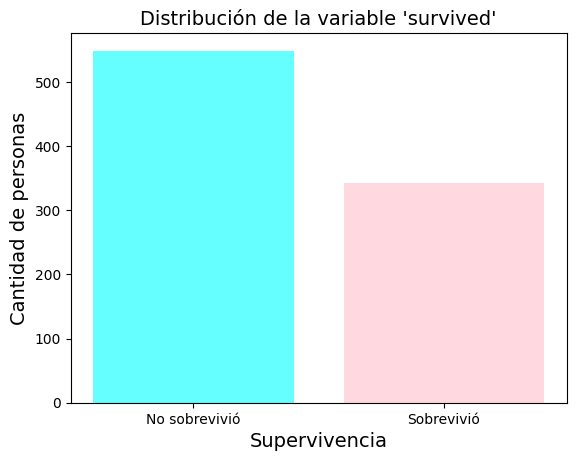

survived
0    0.616162
1    0.383838
Name: proportion, dtype: float64


In [7]:
# Personas que sobrevivieron
counts = titanic['survived'].value_counts()

# Mostrar distribución de la variable target
plt.bar(counts.index, counts.values, color=['cyan', 'pink'], alpha=0.6)
plt.xticks(counts.index, ['No sobrevivió', 'Sobrevivió'])
plt.title("Distribución de la variable 'survived'")
plt.xlabel("Supervivencia")
plt.ylabel("Cantidad de personas")

plt.show()

# Ver la proporción de supervivientes y no supervivientes
print(titanic["survived"].value_counts(normalize=True))


Split en train y test teniendo en cuenta la proporción de las ciudades de embarque, en la que la mayoría son de Southampton.

In [8]:
# Ver la proporción de ciudades de embarque
print(titanic["embarked"].value_counts(normalize=True))

embarked
S    0.724409
C    0.188976
Q    0.086614
Name: proportion, dtype: float64


In [9]:
# Quitar los dos nulos que habia en embarked
titanic = titanic.dropna(subset=["embarked"])  

# Dividir en X (features) y y (target)
X = titanic.drop(columns=["survived"])
y = titanic["survived"]

# Hacer el split manteniendo la proporción de embarque con stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=X["embarked"]
)

# Verificar las proporciones finalmente para comprobar que están similares
print("Proporción de 'embarked' en train:")
print(X_train["embarked"].value_counts(normalize=True))

print("\nProporción de 'embarked' en test:")
print(X_test["embarked"].value_counts(normalize=True))



Proporción de 'embarked' en train:
embarked
S    0.724332
C    0.188467
Q    0.087201
Name: proportion, dtype: float64

Proporción de 'embarked' en test:
embarked
S    0.724719
C    0.191011
Q    0.084270
Name: proportion, dtype: float64


Se hacen imputaciones sobre los valores nulos en X train.

In [10]:
# Revisar valores nulos 
print(X_train.isnull().sum())
print(X_test.isnull().sum())

pclass        0
sex           0
age         138
sibsp         0
parch         0
fare          0
embarked      0
alone         0
dtype: int64
pclass       0
sex          0
age         39
sibsp        0
parch        0
fare         0
embarked     0
alone        0
dtype: int64


In [11]:
# Guardamos media de age
X_train_age_mean = X_train.age.mean()

# Imputar valores nulos
X_train.age.fillna(X_train.age.mean(), inplace=True)  

# Imputar valores nulos también en test (aunque en el enunciado lo ponga después)
X_test.age.fillna(X_train.age.mean(), inplace=True)


C:\Users\tebar\AppData\Local\Temp\ipykernel_12360\3894570725.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_train.age.fillna(X_train.age.mean(), inplace=True)
C:\Users\tebar\AppData\Local\Temp\ipykernel_12360\3894570725.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For

Mini EDA para hacer la selección de features

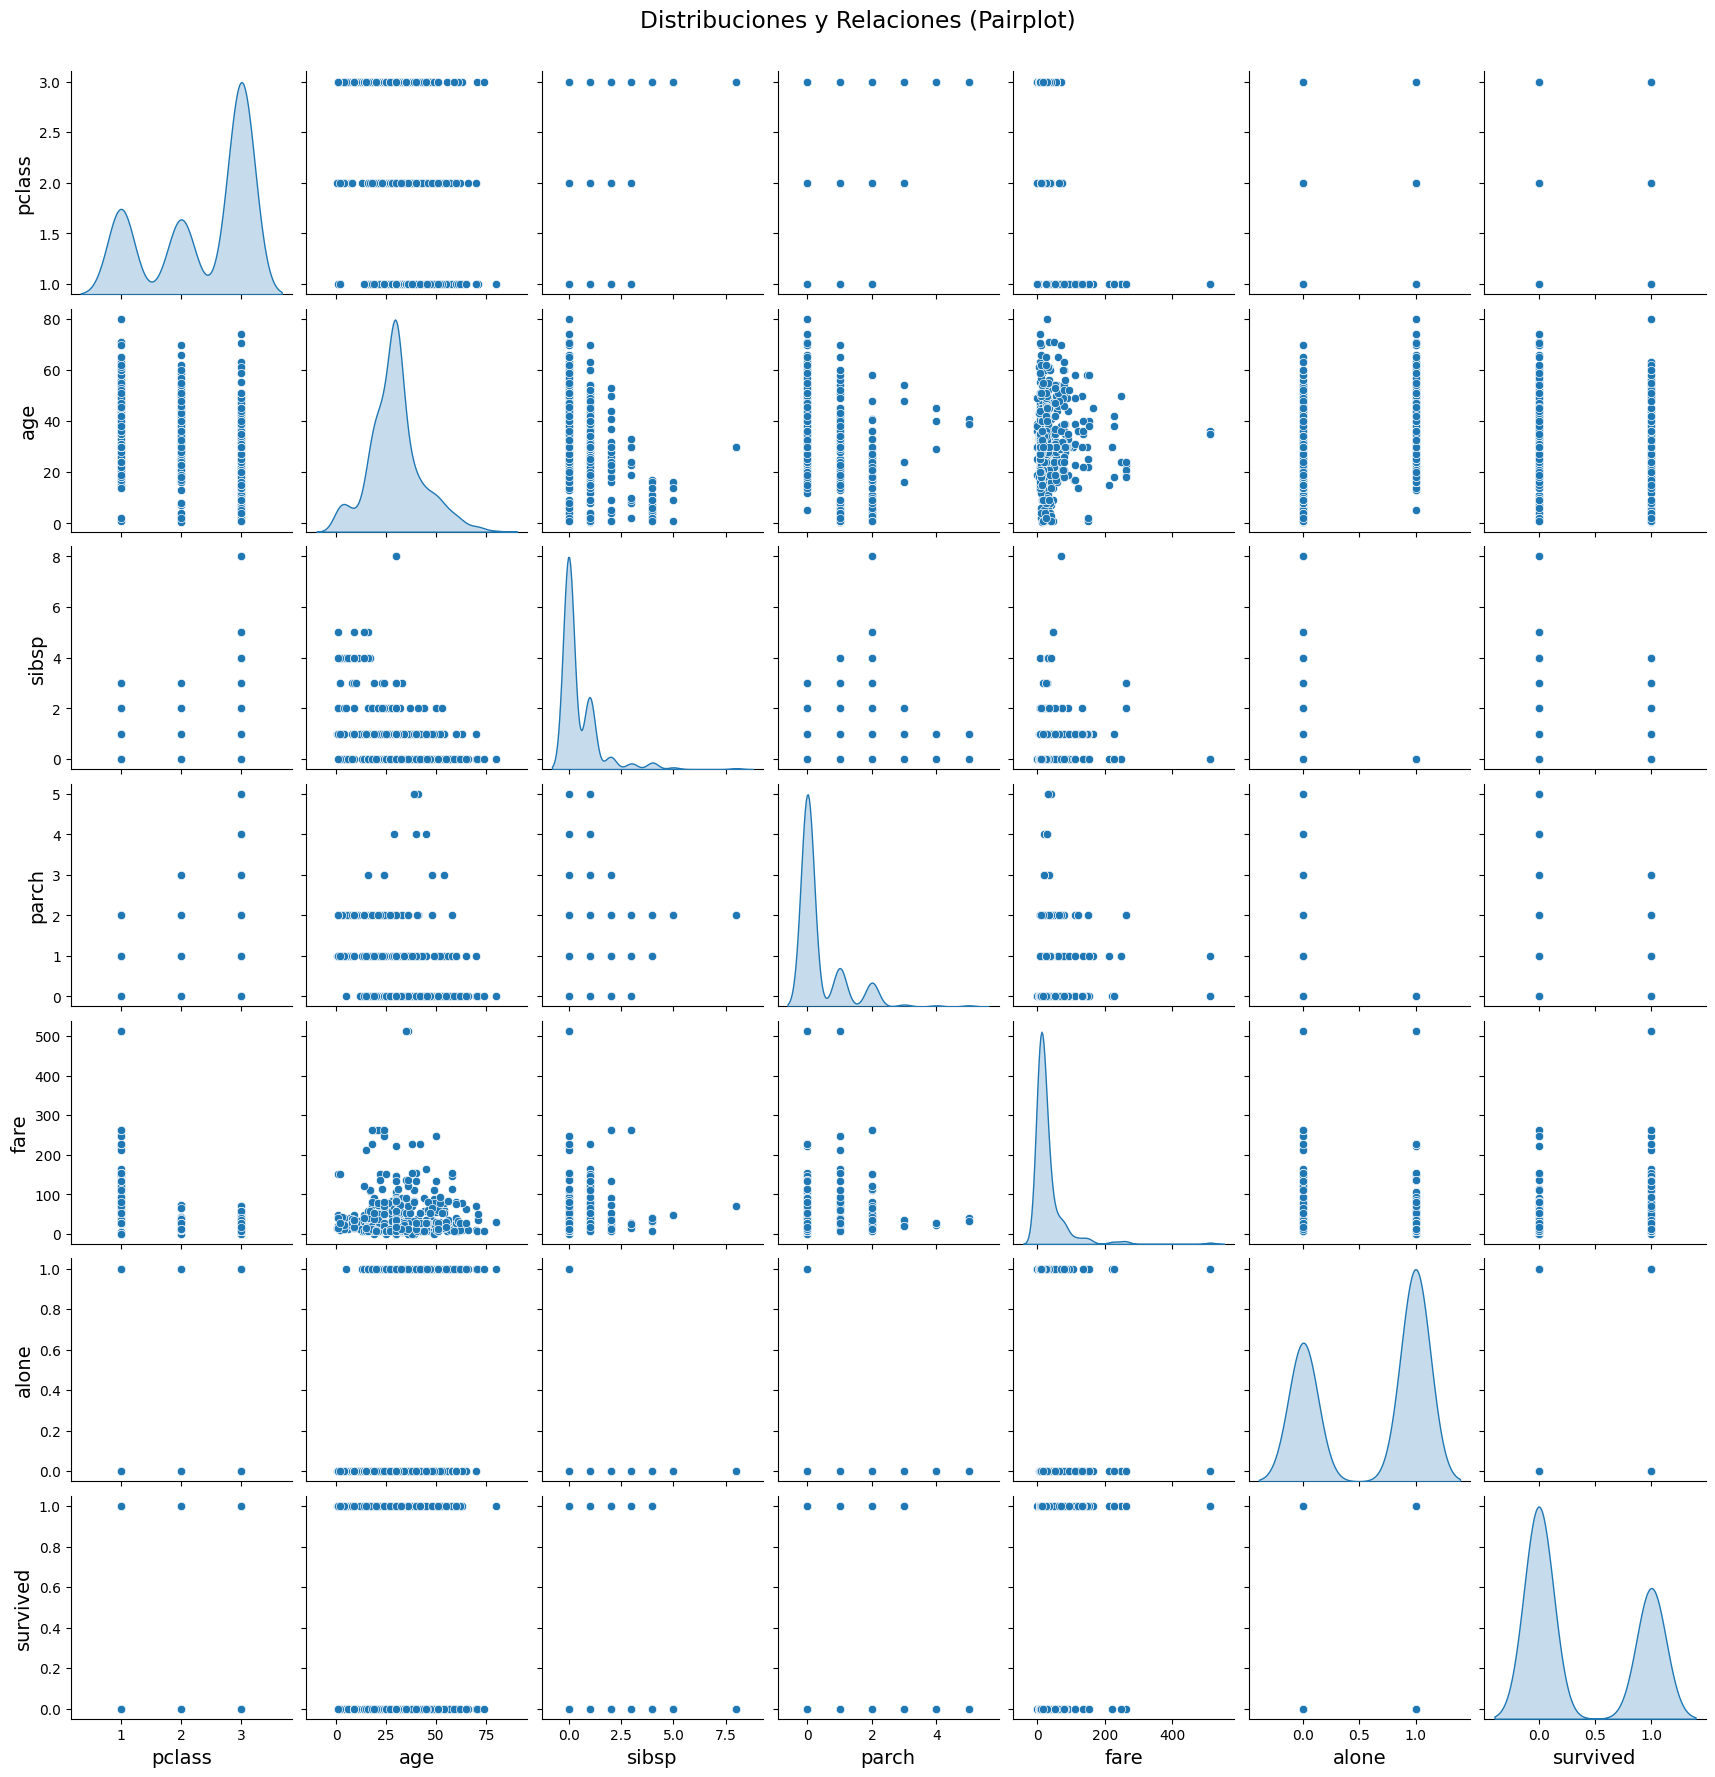

In [12]:
# Los datos de entrenamiento juntando las features con el target de train
titanic_train = pd.concat([X_train, y_train], axis=1)

# Ver en geeneral la dsitribución de las features
sns.pairplot(titanic_train, diag_kind="kde", height=2.5)
plt.suptitle("Distribuciones y Relaciones (Pairplot)", y=1.02)
plt.show()

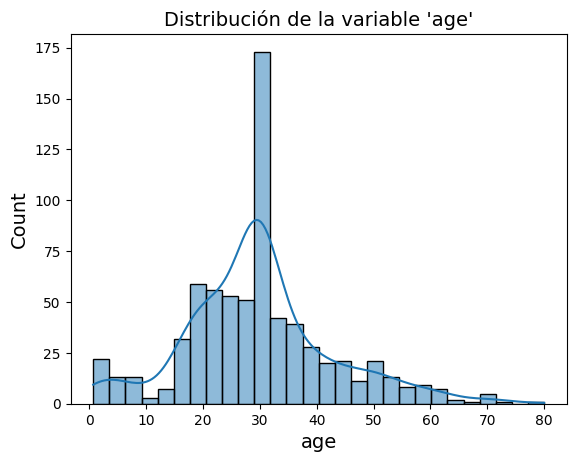

In [13]:
# Graficar la distribución de algunas variables relevantes
sns.histplot(X_train['age'], kde=True)
plt.title("Distribución de la variable 'age'")
plt.show()


C:\Users\tebar\AppData\Local\Temp\ipykernel_12360\3829882504.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="pclass", y=y_train, data=X_train, errorbar=None, palette=["cyan", "pink", "yellow"], alpha=0.5)


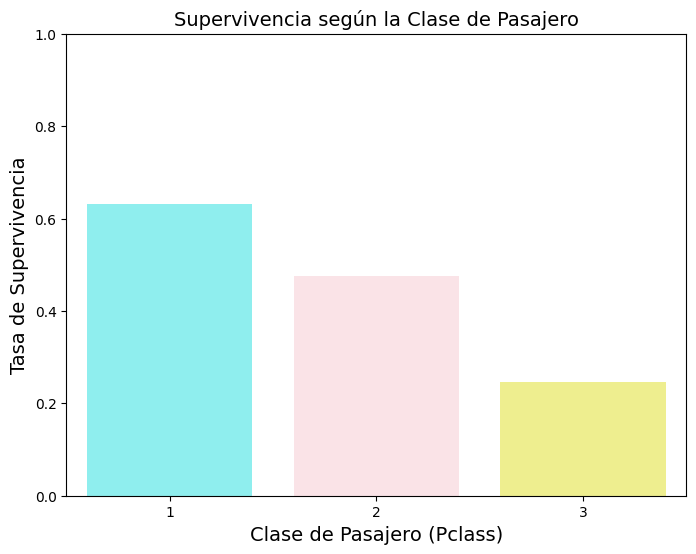

In [14]:
# Graficar la distribución de algunas variables relevantes
plt.figure(figsize=(8, 6))
sns.barplot(x="pclass", y=y_train, data=X_train, errorbar=None, palette=["cyan", "pink", "yellow"], alpha=0.5)
plt.xlabel("Clase de Pasajero (Pclass)")
plt.ylabel("Tasa de Supervivencia")
plt.title("Supervivencia según la Clase de Pasajero")
plt.ylim(0, 1)  
plt.show()


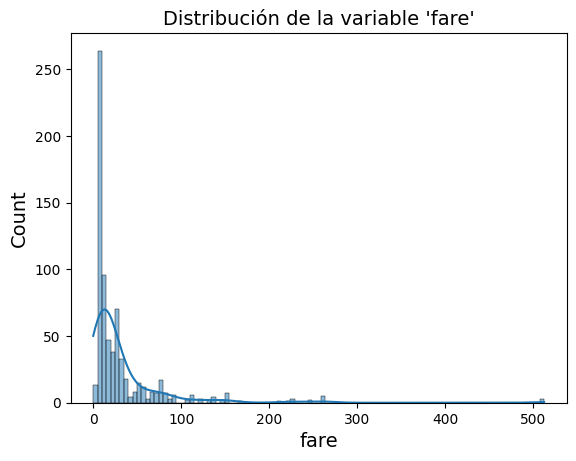

In [15]:
# Graficar la distribución de algunas variables relevantes
sns.histplot(X_train['fare'], kde=True)
plt.title("Distribución de la variable 'fare'")
plt.show()


In [16]:
titanic_train.head()

,pclass,sex,age,sibsp,parch,fare,embarked,alone,survived
46,3,male,29.710454,1,0,15.500,Q,False,0
230,1,female,35.000000,1,0,83.475,S,False,1
657,3,female,32.000000,1,1,15.500,Q,False,0
888,3,female,29.710454,1,2,23.450,S,False,0
809,1,female,33.000000,1,0,53.100,S,False,1


In [17]:
# Para obtener la correlación con el target, vamos a pasar las variables a numéricas
titanic_train_numeric = titanic_train.copy()

titanic_train_numeric = pd.get_dummies(titanic_train_numeric, columns=["sex", "embarked", "alone"], drop_first=True)


# Crear una matriz de correlación
correlation_matrix = titanic_train_numeric.corr()
correlation_matrix

,pclass,age,sibsp,parch,fare,survived,sex_male,embarked_Q,embarked_S,alone_True
pclass,1.000000,-0.338337,0.043680,0.004071,-0.549207,-0.333723,0.168902,0.204470,0.097922,0.158879
age,-0.338337,1.000000,-0.274098,-0.196451,0.080506,-0.047382,0.101260,-0.008001,-0.040837,0.174005
sibsp,0.043680,-0.274098,1.000000,0.427283,0.167344,-0.006820,-0.134076,-0.040447,0.060541,-0.629834
parch,0.004071,-0.196451,0.427283,1.000000,0.194179,0.091666,-0.272108,-0.110133,0.062842,-0.597770
fare,-0.549207,0.080506,0.167344,0.194179,1.000000,0.268742,-0.197744,-0.111624,-0.179166,-0.268774
survived,-0.333723,-0.047382,-0.006820,0.091666,0.268742,1.000000,-0.571604,0.024312,-0.170405,-0.200779
sex_male,0.168902,0.101260,-0.134076,-0.272108,-0.197744,-0.571604,1.000000,-0.074192,0.156795,0.329875
embarked_Q,0.204470,-0.008001,-0.040447,-0.110133,-0.111624,0.024312,-0.074192,1.000000,-0.501013,0.096905
embarked_S,0.097922,-0.040837,0.060541,0.062842,-0.179166,-0.170405,0.156795,-0.501013,1.000000,0.042087
alone_True,0.158879,0.174005,-0.629834,-0.597770,-0.268774,-0.200779,0.329875,0.096905,0.042087,1.000000


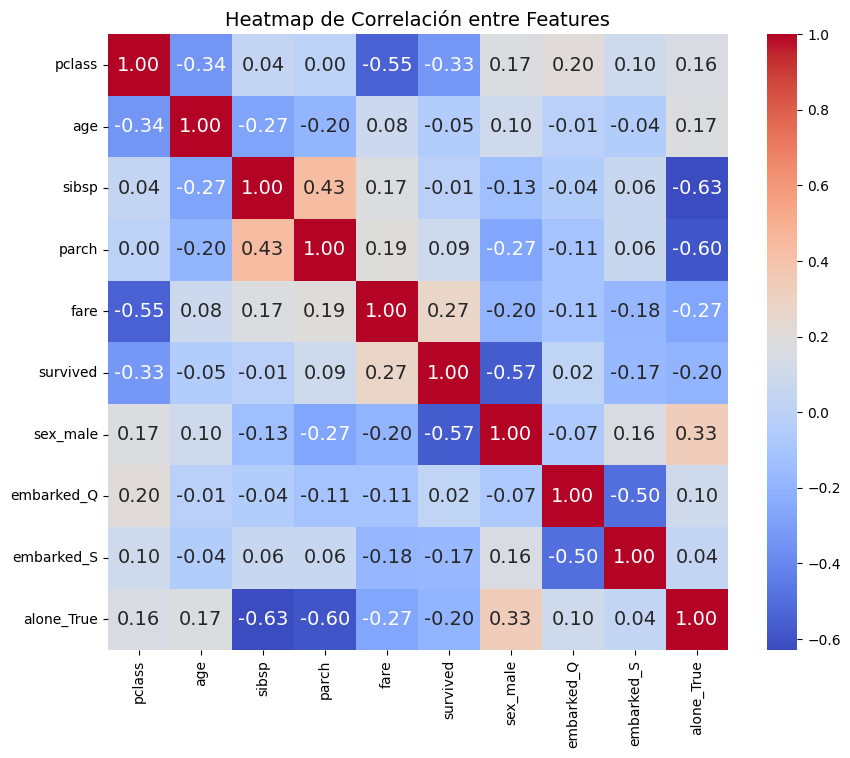

In [18]:
# Visualizar el heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap de Correlación entre Features")
plt.show()
# Las más correladas son sex, fare y class.

Hacemos el tratamiento de variables en X train y test con get_dummies.

In [19]:
# Convertir las variables categóricas en variables dummy (One-Hot Encoding)
X_train = pd.get_dummies(X_train, columns=["sex", "embarked", "alone"], drop_first=True)
X_test = pd.get_dummies(X_test, columns=["sex", "embarked", "alone"], drop_first=True)

Crear el modelo de regresión, entrenar y hacer predicciones (porque el X test ya estaba con las modificaciones adecuadas también)

In [20]:
# Inicializar el modelo de regresión logística
log_reg = LogisticRegression(max_iter=10000, random_state=42)

# Entrenar el modelo
log_reg.fit(X_train, y_train)

# Hacer predicciones en el conjunto de test
y_pred = log_reg.predict(X_test)

Evaluación del modelo. FALTA LAS GRAFICAS DE LAS MATRICES DE CONFUSION

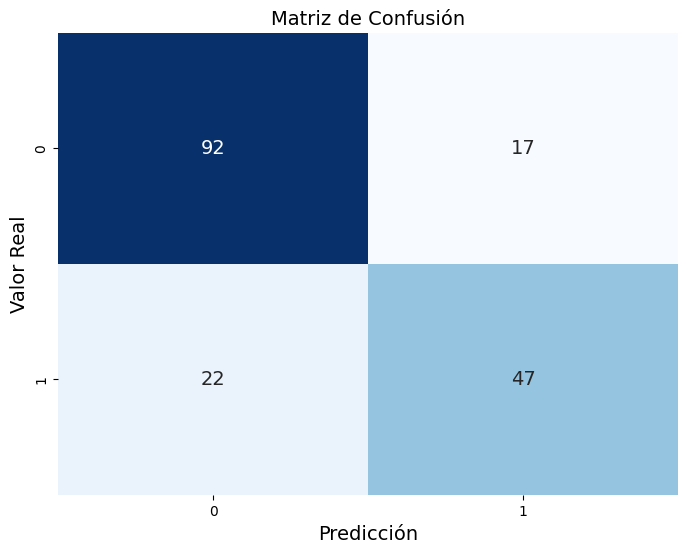

In [21]:
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Gráfica
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicción")
plt.ylabel("Valor Real")
plt.title("Matriz de Confusión")
plt.show()


In [22]:
# Generar el informe de clasificación
print("\nInforme de clasificación:")
print(classification_report(y_test, y_pred))


Informe de clasificación:
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       109
           1       0.73      0.68      0.71        69

    accuracy                           0.78       178
   macro avg       0.77      0.76      0.77       178
weighted avg       0.78      0.78      0.78       178



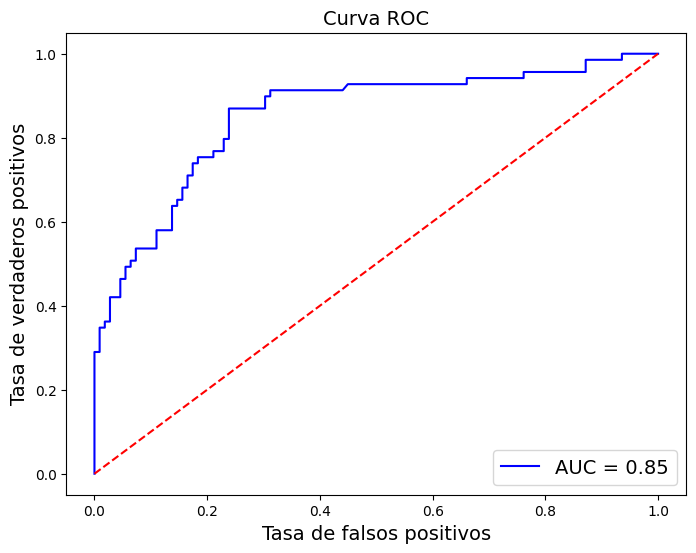

In [23]:
# Calcular y mostrar la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('Curva ROC')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.legend(loc='lower right')
plt.show()